In [1]:
#!pip3 install lightgbm
import pandas as pd
import numpy as np
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from collections import Counter
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
import lightgbm 
from lightgbm import LGBMRegressor

In [2]:
data_all = pd.read_csv("Iowa_Liquor_Sales.csv")
print("The entire dataset dimension: ",data_all.shape) #19666763, 24)
print("Attributes:",data_all.columns) # 19666763, 24)

The entire dataset dimension:  (19666763, 24)
Attributes: Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object')


In [3]:
# check missing values 
print("Missing values:\n",data_all.isnull().sum()) 

Missing values:
 Invoice/Item Number            0
Date                           0
Store Number                   0
Store Name                     0
Address                    79927
City                       79926
Zip Code                   79971
Store Location           1886023
County Number             156731
County                    156729
Category                   16974
Category Name              25040
Vendor Number                  5
Vendor Name                    3
Item Number                    0
Item Description               0
Pack                           0
Bottle Volume (ml)             0
State Bottle Cost             10
State Bottle Retail           10
Bottles Sold                   0
Sale (Dollars)                10
Volume Sold (Liters)           0
Volume Sold (Gallons)          0
dtype: int64


In [4]:
missing_records_num = data_all[data_all.isnull().any(axis=1)].shape[0]
missing_records_num #95103
print(f"Missing value percentage is {100*missing_records_num / data_all.shape[0]}%.") #10.062037153750213
print(f"Total missing values is {sum(data_all.isnull().sum())}.") #2481359
print(f"Average number of null values per record" \
      f" is {sum(data_all.isnull().sum()) / missing_records_num}.") #1.253922805712533.

Missing value percentage is 10.062037153750213%.
Total missing values is 2481359.
Average number of null values per record is 1.253922805712533.


In [5]:
# drop records with missing values 
data_all = data_all.dropna()

In [6]:
data = data_all
data.Category.value_counts()
print(data.shape)#(17687886, 24)

(17687886, 24)


# Pre-processing

In [7]:
county_counts = data.groupby("County").size().shape[0] #county counts 200
real_county_counts = data.groupby("County Number").size().shape[0] #99

data["County"] = data["County"].str.title() #case sensitive
exist_county_counts = data.groupby("County").size().shape #103

data["City"] = data["City"].str.title() #case sensitive

In [8]:
#pd.set_option('display.max_rows', 10)
county_countN_df = data.loc[:,["County","County Number","Date"]].groupby(["County","County Number"]).count().reset_index()
print("Counties with the same county number but conflicting names")
county_countN_df["County Number"].value_counts()
print(county_countN_df.loc[county_countN_df["County Number"].isin([71.0, 78.0,17.0, 11.0]),:])

data.County = data.County.replace(["Buena Vist","Cerro Gord",
                                   "O'Brien","O'brien","Pottawatta"], 
                                  ["Buena Vista","Cerro Gordo",
                                    "Obrien","Obrien", "Pottawattamie"])

Counties with the same county number but conflicting names
           County  County Number    Date
10     Buena Vist           11.0   71360
11    Buena Vista           11.0   89480
17     Cerro Gord           17.0  211992
18    Cerro Gordo           17.0  228400
72        O'Brien           71.0   63180
73         Obrien           71.0   69812
80     Pottawatta           78.0  296991
81  Pottawattamie           78.0  299164


In [9]:
# convert data types 
data["Date"]  = pd.to_datetime(data['Date'],format='%m/%d/%Y')
data['year'] = pd.DatetimeIndex(data['Date']).year
data['month'] = pd.DatetimeIndex(data['Date']).month
data["month"] = data["month"].astype("category")
data['day'] = pd.DatetimeIndex(data['Date']).day
data["day"] = data["day"].astype("category")
data["week_of_day"] = data["Date"].dt.dayofweek+1
data["week_of_day"] = data["week_of_day"].astype("category")

data["Store Number"] = data["Store Number"].astype("category")
data["Item Number"] = data["Item Number"].astype("category")
data["County Number"] = data["County Number"].astype("int")
data["County Number"] = data["County Number"].astype("category")
data["Category"] = data["Category"].astype("int")
data["Category"] = data["Category"].astype("category")
data["City"] = data["City"].astype("category")
data["Sale (Dollars)"] = data["Sale (Dollars)"].astype("str")
data["State Bottle Cost"] = data["State Bottle Cost"].astype("str")
data["State Bottle Retail"] = data["State Bottle Retail"].astype("str")

data.loc[:,"Sale (Dollars)"] = data.loc[:, "Sale (Dollars)"].str[1:]
data.loc[:,"State Bottle Cost"] = data.loc[:, "State Bottle Cost"].str[1:]
data.loc[:,"State Bottle Retail"] = data.loc[:, "State Bottle Retail"].str[1:]
data["Sale (Dollars)"] = data["Sale (Dollars)"].astype("float")
data["State Bottle Cost"] = data["State Bottle Cost"].astype("float")
data["State Bottle Retail"] = data["State Bottle Retail"].astype("float")

In [10]:
# covert string representation of city to interger representation
encoder = preprocessing.LabelEncoder().fit(data.City)
data["encoded_city"] = encoder.transform(data.City)
data["encoded_city"] = data["encoded_city"].astype("category")

In [11]:
data[data["year"].isin([2019, 2020])].year.value_counts()

2019    2158261
2020    1760082
Name: year, dtype: int64

In [12]:
# remove potential errors 
cond1 = data["Bottle Volume (ml)"] == 0
cond2 = data["State Bottle Cost"] == 0
cond3 = data["State Bottle Retail"] == 0
cond4 = data["Sale (Dollars)"] == 0
cond5 = data["Bottles Sold"] ==0
cond6 = data["Volume Sold (Liters)"] ==0
data = data.loc[~(cond1|cond2|cond3|cond4|cond5|cond6),:] 
data = data[data["year"].isin([2019, 2020])]
data.shape
# (3448996, 29)

(3448996, 29)

In [13]:
data["Store Loc"] = data["Store Location"].map(lambda x:str(re.findall(r"\((.+?)\)",x)[0]).split(" "))
data["latitude"] = data["Store Loc"].map(lambda x:x[0])
data["longitude"] = data["Store Loc"].map(lambda x:x[1])

data["latitude"]  = data["latitude"].astype("float")
data["longitude"] = data["longitude"].astype("float")
data_filtered = data.loc[(data['longitude'] > 40.396764305572) & (data['longitude'] < 43.580390855608) & 
            (data['latitude'] < -90.087890625) & (data['latitude'] > -96.767578125)]

#-96.767578125 40.396764305572, -96.767578125 43.580390855608, -90.087890625 43.580390855608, -90.087890625 40.396764305572 
#https://geodata.iowa.gov/dataset/boundary-state-iowa
#original = (3448996, 32), after removing = ((3448152,, 32)
data_filtered.shape# 

(3448152, 32)

In [14]:
# check whether volume sold = bottlesold * bottle volume 
kk = data_filtered["Bottles Sold"]*data_filtered["Bottle Volume (ml)"]/1000 
mismatch = kk != data_filtered["Volume Sold (Liters)"] #295009
data_filtered = data_filtered.loc[~mismatch,:]
data_filtered.shape #3377142, 32

(3377142, 32)

In [15]:
def drop_3IQR_val(df, col_name):
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    IQR = q3 - q1
    df_new = df.drop(df[(df[col_name] > q3 + 3*IQR) | (df[col_name] < q1 - 3*IQR)].index)
    print("feature = ",col_name, ":",df.shape[0]- df_new.shape[0],"records removed",df_new.shape[0],"records remaning" )
    return (df_new)

targeted_features = ["Volume Sold (Liters)","State Bottle Cost",
                     "State Bottle Retail","Pack"]
for i in targeted_features:
    data_filtered = drop_3IQR_val(data_filtered, i)
#3125315

feature =  Volume Sold (Liters) : 85933 records removed 3291209 records remaning
feature =  State Bottle Cost : 58701 records removed 3232508 records remaning
feature =  State Bottle Retail : 553 records removed 3231955 records remaning
feature =  Pack : 106640 records removed 3125315 records remaning


In [16]:
num_store_per_county = data_filtered[['Store Number','County Number',"Invoice/Item Number"]].groupby(["County Number","Store Number"])
z = list(num_store_per_county.groups.keys())
store_num_counter = Counter(elem[0] for elem in z)
df_store = pd.DataFrame.from_dict(store_num_counter, orient = "index").reset_index()
df_store.columns = ["County Number","store_num"]

data_filtered = pd.merge(data_filtered, df_store, how = "left", on = ['County Number'])
data_filtered.shape #(3125315, 33)

(3125315, 33)

In [17]:
data_filtered = data_filtered[['year', 'month', 'day', 'latitude','longitude',
                            'week_of_day','Pack','City', 'Category','County Number',
                            'County', 'store_num', 'Item Number','Bottle Volume (ml)',
                            'State Bottle Cost', 'State Bottle Retail',
                            'Volume Sold (Liters)','Store Number', 'encoded_city']]
data_filtered.rename(columns = {"County Number":"county_number", 
                             "Volume Sold (Liters)":"volume_sold",
                             "Pack":"pack",
                             "City":"city","Category":"category",
                             "Store Number":"store_number",
                             "State Bottle Retail":"retail_price",
                             "State Bottle Cost":"cost_price",
                             "County Number":"county_number",
                             "County": "county",
                             "Item Number":"item_number",
                             "Bottle Volume (ml)":"bottle_volume"}, inplace = True)

In [18]:
data_filtered["county_number"] = data_filtered["county_number"].astype("category")
data_filtered.dtypes

year                int64
month            category
day              category
latitude          float64
longitude         float64
week_of_day      category
pack                int64
city             category
category         category
county_number    category
county             object
store_num           int64
item_number      category
bottle_volume       int64
cost_price        float64
retail_price      float64
volume_sold       float64
store_number     category
encoded_city     category
dtype: object

In [19]:
d_2019 = data_filtered.year ==2019
d_2020 = data_filtered.year ==2020

data_2019 = data_filtered.loc[d_2019,:]
data_2020 = data_filtered.loc[~d_2019,:]

data_final_2019 = data_2019.sample(n = 100000, replace = False, random_state = 100)
data_final_2020 = data_2020.sample(n = 100000, replace = False, random_state = 100)

In [20]:
population_2019 = pd.read_csv("2019_population.csv")
population_2020 = pd.read_csv("2020_population.csv")
population_2019 = population_2019[["population",'county']]
population_2020 = population_2020[["population",'county']]
#population.population = population.population.astype("int")
data_final_2019 = pd.merge(data_final_2019,population_2019,how = "left")
data_final_2020 = pd.merge(data_final_2020,population_2020,how = "left")

In [21]:
data_final_2019.to_csv("data_2019_100k.csv")
data_final_2020.to_csv("data_2020_100k.csv")

# Application

In [22]:
def covert_data_types(name):
    # load data
    data = pd.read_csv(name)
    data = data.iloc[:, 1:]
    data.info()
    
    data["city"] = data["city"].astype("category")
    data["category"] = data["category"].astype("category")
    data["county_number"] = data["county_number"].astype("category")
    data["item_number"] = data["item_number"].astype("category")
    data["store_number"] = data["store_number"].astype("category")
    data["encoded_city"] = data["encoded_city"].astype("category")
    data["population"] = data["population"].astype("int")
    return data

data_train = covert_data_types("data_200k_latest.csv")
data_2019 = covert_data_types("data_2019_100k.csv")
data_2020 = covert_data_types("data_2020_100k.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   week_of_day    200000 non-null  int64  
 1   pack           200000 non-null  int64  
 2   city           200000 non-null  object 
 3   category       200000 non-null  int64  
 4   county_number  200000 non-null  int64  
 5   county         200000 non-null  object 
 6   store_num      200000 non-null  int64  
 7   item_number    200000 non-null  int64  
 8   bottle_volume  200000 non-null  int64  
 9   cost_price     200000 non-null  float64
 10  retail_price   200000 non-null  float64
 11  volume_sold    200000 non-null  float64
 12  store_number   200000 non-null  int64  
 13  encoded_city   200000 non-null  int64  
 14  population     200000 non-null  int64  
dtypes: float64(3), int64(10), object(2)
memory usage: 22.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 ent

In [23]:
# train-test splitting 2019
X = data_train[['week_of_day', 'pack', 'store_num', 'bottle_volume', 
                'cost_price', 'retail_price', 'population', 'encoded_city',
                'category', 'county_number', 'store_number', 'item_number']]

y = data_train.volume_sold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

X_test_2019 = data_2019[['week_of_day', 'pack', 'store_num', 'bottle_volume', 
                'cost_price', 'retail_price', 'population', 'encoded_city',
                'category', 'county_number', 'store_number', 'item_number']]
y_test_2019 = data_2019.volume_sold

X_test_2020 = data_2020[['week_of_day', 'pack', 'store_num', 'bottle_volume', 
                'cost_price', 'retail_price', 'population', 'encoded_city',
                'category', 'county_number', 'store_number', 'item_number']]
y_test_2020 = data_2020.volume_sold

In [24]:
depth = 16
leaves = 99

lgbm_model = LGBMRegressor(max_depth= depth,num_leaves = leaves,random_state= 100)
lgbm_model.fit(X_train, y_train)

pred_2019 = lgbm_model.predict(X_test_2019)
lgbm_rmse_2019 = np.sqrt(mean_squared_error(y_test_2019, pred_2019))
print("2019RMSE: " + str(lgbm_rmse_2019))

pred_2020 = lgbm_model.predict(X_test_2020)
lgbm_rmse_2020 = np.sqrt(mean_squared_error(y_test_2020, pred_2020))
print("2020RMSE: " + str(lgbm_rmse_2020))

2019RMSE: 4.3158329066089
2020RMSE: 4.374655878169914


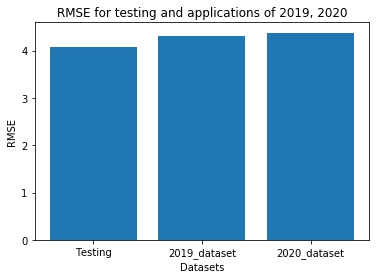

In [25]:
x = ["Testing", "2019_dataset", "2020_dataset"]
lgbm_rmse_testing = 4.071771630523179
y = [lgbm_rmse_testing, lgbm_rmse_2019, lgbm_rmse_2020]
plt.bar(x, y)
plt.xlabel("Datasets")
plt.ylabel("RMSE")
plt.title("RMSE for testing and applications of 2019, 2020")
plt.show()